# Ngatamariki Microseismicity Annual Report Data Plots, for Mercury Energy

**Import modules, etc**

In [1]:
#import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import OSM
#from cartopy.io.img_tiles import StamenTerrain

import pandas as pd
import numpy as np
import pyproj
from math import floor

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from matplotlib import patheffects
import matplotlib.gridspec as gridspec
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
#full width notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Functions

**Array version of Haversine formula to calculate distance between two points**

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

**Plot distance scale (and north arrow) on plot. Reference in scale_bar function documentation**

In [4]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)
    
# or to use m instead of km
# scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
# or to use miles instead of km
# scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')

#need specific font to show triangle for north arrow
mpl.rc('font', family='DejaVu Sans')

## Set Up Parameters

**Plot area**

In [42]:
lonmin = 176.1470
lonmax = 176.2429
latmin = -38.5863
latmax = -38.5096

#northern map extents
northlonmin = 176.1636
northlonmax = 176.1937
northlatmin = -38.5421
northlatmax = -38.5252

EDIT SOUTH

#southern map extents
southlonmin = 176.1636
southlonmax = 176.1937
sourthlatmin = -38.5421
southlatmax = -38.5252

**Times**

In [16]:
start = '2012-05-15T00:00:00'
thisrpt = '2016-01-01T00:00:00'
end = '2017-01-01T00:00:00'

#previous report period
lastrpt = '2015-01-01T00:00:00'
lastend = '2016-01-01T00:00:00'

#report period before that
last2rpt = '2014-01-01T00:00:00'
last2end = '2015-01-01T00:00:00'

## Seismicity from Local Network

**HypoDD hypocentres for rotnga, first event 2015-05-15**

In [7]:
#this file needs to be kept up to date as new data are processed
hypdd = pd.read_csv('rotnga_hypodd_all.csv', usecols=[3,4,5,6,7,8], parse_dates={"ot" : ['YYYY-MM-DD','hh:mm:sec']}, index_col='ot')

In [8]:
hypdd.head()

,latitude,longitude,z,ml
ot,,,,
2012-05-15 05:28:23,-38.618091,176.208626,2.487,0.6
2012-05-15 00:25:36,-38.605111,176.201432,3.434,0.6
2012-05-16 05:39:38,-38.599679,176.207178,5.398,0.7
2012-05-17 07:40:40,-38.600179,176.206283,2.046,0.7
2012-05-23 00:29:54,-38.603007,176.204899,3.758,1.2


In [9]:
len(hypdd)

4560

**Filter for plotting area**

In [11]:
#filter hypocentres to plot area, to just get ngatamariki
hypdd = hypdd[(hypdd['longitude']>lonmin)&(hypdd['longitude']<lonmax)&(hypdd['latitude']>latmin)&(hypdd['latitude']<latmax)]

In [12]:
len(hypdd)

1314

In [17]:
#filter hypocentres for reporting period, to get rotokawa for just reporting period
hyprpt = hypdd[(hypdd.index>thisrpt)&(hypdd.index<end)]

In [18]:
hyprpt.head()

,latitude,longitude,z,ml
ot,,,,
2016-01-03 21:10:36,-38.538131,176.180143,1.408,0.9
2016-01-06 00:19:44,-38.535933,176.185010,3.672,0.6
2016-01-06 07:43:40,-38.563688,176.193587,3.308,0.8
2016-01-06 11:11:04,-38.534880,176.182926,2.310,1.2
2016-01-06 11:41:28,-38.535303,176.182503,2.258,1.2


In [19]:
len(hyprpt)

265

In [20]:
hyprpt['ml'].describe()

count    265.000000
mean       1.112075
std        0.312985
min        0.400000
25%        0.900000
50%        1.100000
75%        1.200000
max        2.600000
Name: ml, dtype: float64

In [23]:
hyprpt[hyprpt['ml']>=3]

,latitude,longitude,z,ml
ot,,,,


In [24]:
hyprpt[hyprpt['ml']>=2]

,latitude,longitude,z,ml
ot,,,,
2016-01-18 04:03:57,-38.574211,176.207780,3.298,2.6
2016-01-18 04:05:31,-38.575435,176.208643,2.942,2.1
2016-04-02 01:01:08,-38.536812,176.175391,1.639,2.6
2016-06-26 02:33:14,-38.534538,176.175000,2.433,2.2
2016-09-20 03:54:01,-38.536369,176.169824,2.091,2.2
2016-11-13 12:06:48,-38.573641,176.197852,3.405,2.0


**Plot hypocentres on Open Street Map basemap**

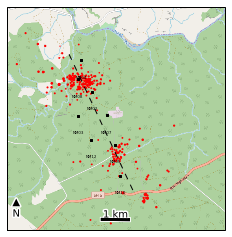

In [38]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([lonmin, lonmax, latmin, latmax])
#ax.add_image(imagery, 15)
ax.add_image(imagery, 13)
#ax.gridlines()

#hypocentres, symbol size=magnitude squared, as scatter symbol size is symbol area, square gives 'pleasing' image
plt.scatter(hyprpt['longitude'], hyprpt['latitude'], color='red', marker='o', s=hyprpt['ml']**2, transform=ccrs.Geodetic())

#plot wells
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wells.dat', sep='\s+', names=names)
plt.scatter(wells['lon'], wells['lat'], color='black', marker='s', s=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-15)
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)
#section line
plt.plot([176.1742,176.2024], [-38.5260,-38.5730], color='black', linestyle='--', marker='None', transform=ccrs.Geodetic())

scale_bar(ax, ccrs.Mercator(), 1)

plt.savefig('mercury_thisreport_map.png', dpi=400)

**Plot northern area**

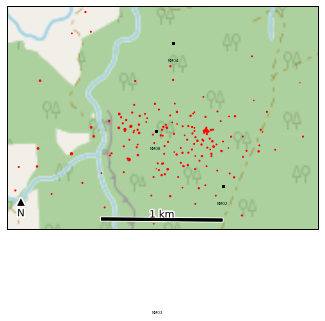

In [48]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([northlonmin, northlonmax, northlatmin, northlatmax])
#ax.add_image(imagery, 15)
ax.add_image(imagery, 13)

#hypocentres, symbol size=magnitude squared, as scatter symbol size is symbol area, square gives 'pleasing' image
plt.scatter(hyprpt['longitude'], hyprpt['latitude'], color='red', marker='o', s=hyprpt['ml']**2, transform=ccrs.Geodetic())

#plot wells
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wellsnorth.dat', sep='\s+', names=names)
plt.scatter(wells['lon'], wells['lat'], color='black', marker='s', s=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-15)
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

scale_bar(ax, ccrs.Mercator(), 1)

plt.savefig('mercury_thisreport_map_north.png', dpi=400)

**Plot southern area**

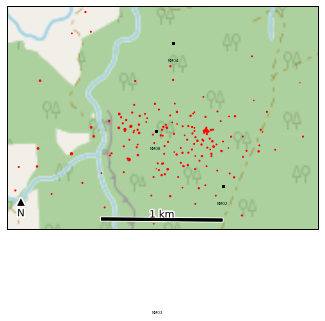

In [48]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([northlonmin, northlonmax, northlatmin, northlatmax])
#ax.add_image(imagery, 15)
ax.add_image(imagery, 13)

#hypocentres, symbol size=magnitude squared, as scatter symbol size is symbol area, square gives 'pleasing' image
plt.scatter(hyprpt['longitude'], hyprpt['latitude'], color='red', marker='o', s=hyprpt['ml']**2, transform=ccrs.Geodetic())

#plot wells
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wellsnorth.dat', sep='\s+', names=names)
plt.scatter(wells['lon'], wells['lat'], color='black', marker='s', s=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-15)
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

scale_bar(ax, ccrs.Mercator(), 1)

plt.savefig('mercury_thisreport_map_north.png', dpi=400)

**Wells**

In [40]:
#wells for plotting
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wells.dat', sep='\s+', names=names)
wells

,lon,lat,name
0,176.196500,-38.567700,NM10
1,176.183760,-38.555403,NM12
2,176.184444,-38.538835,NM02
3,176.178131,-38.547050,NM03
4,176.179636,-38.528002,NM04
5,176.194408,-38.557069,NM05
6,176.190712,-38.547030,NM07
7,176.177982,-38.534617,NM08


**Cross-section**

In [ ]:
#export data
hyprpt.to_csv('section.csv', header=False)

#run external program, temporary solution
!section.csh

In [ ]:
#read output of external program
names=['p', 'q', 'z', 'ml']
seceqs = pd.read_csv('section.dat', sep='\s+', names=names)
#pq nomerclature is that used by GMT project command http://gmt.soest.hawaii.edu/doc/5.4.2/project.html

In [ ]:
seceqs.head()

In [ ]:
#read well data (pre-projected)
names=['p', 'q', 'z']
well04 = pd.read_csv('well_section_04.dat', sep='\s+', names=names)
well05 = pd.read_csv('well_section_05.dat', sep='\s+', names=names)
well06 = pd.read_csv('well_section_06.dat', sep='\s+', names=names)
well20 = pd.read_csv('well_section_20.dat', sep='\s+', names=names)

In [ ]:
well04.head()

In [ ]:
#size scaled to give 1:1 ratio
fig = plt.figure(figsize=(4.48,6.3))

#earthquakes
plt.scatter(x=seceqs['p'], y=seceqs['z'], s=2*seceqs['ml']**2, color='black', marker='o', linewidth=0.3)
# wells
plt.plot(well04['p'], well04['z'], color='red')
plt.plot(well05['p'], well05['z'], color='red')
plt.plot(well06['p'], well06['z'], color='red')
plt.plot(well20['p'], well20['z'], color='red')
#well labels
plt.text(1.05, 0.1, 'RK04', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(-0.18, 0.1, 'RK05', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(-0.9, 0.1, 'RK06', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(1.3, 0.1, 'RK20', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
#section orientations
plt.text(-1.9, -0, 'NW', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(2.4, -0, 'SE', verticalalignment='bottom', horizontalalignment='right', fontsize=10)

plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.xlim([-1.99,2.49])
plt.ylim([-0.3,6])
plt.ylabel('Depth (km)')
plt.xlabel('Distance from RK05(km)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('mercury_thisreport_section.png', dpi=200)

**Magnitude-time - Reporting period only**

In [ ]:
#magnitude vs time
ax = hyprpt.plot(y='ml', color='black', marker='o', linewidth=0.3, linestyle='None', legend=False, figsize=(15,5))
ax.xaxis.grid()
ax.yaxis.grid()

ax.set_ylim([0,4.2])
ax.set_ylabel('Magnitude')
ax.tick_params(labelright = True)

plt.tight_layout()
plt.savefig('mercury_thisreport_time-series.png', dpi=200)

**Magnitude-time and cumulative number - Complete period since 2008 & location within 5 km of reference point**

In [ ]:
#get hypodd and hyprot again, so am dealing with orginal data
hypdd = pd.read_csv('rotnga_hypodd_all.csv', usecols=[3,4,5,6,7,8], parse_dates={"ot" : ['YYYY-MM-DD','hh:mm:sec']}, index_col='ot')
names=['nzmg_e', 'nzmg_n', 'latitude', 'longitude', 'z', 'ml', 'date', 'time']
hyprot = pd.read_csv('rotokawa_2008-2012-05-13.dat', usecols=[2,3,4,5,6,7], names=names, sep='\s+', parse_dates={"ot" : ['date','time']}, index_col='ot')
#append to get complete time-series
hypall = hyprot.append(hypdd)

In [ ]:
#calculate distance from reference point
hypall['dist'] = haversine_np(hypall['longitude'],hypall['latitude'],lonref,latref)
len(hypall)

In [ ]:
#distance within 5 km
hypall = hypall[hypall['dist']<=5]

In [ ]:
len(hypall)

In [ ]:
#eqs m>=0.8, magnitude of completeness in published study (2008-2012)
hypcmp = hypall[hypall['ml']>=0.8]
#make a column containing event number (should be a better way of doing this)
hypcmp.reset_index(inplace=True)
hypcmp['evnum'] = hypcmp.index+1
hypcmp.set_index('ot', inplace=True, drop=True)

In [ ]:
hypcmp.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(22,10))

#distance vs time
hypall.plot(y='ml', color='black', marker='o', linewidth=0.3, linestyle='None', legend=False, ax=ax1)

#plot labels
ax1.text('2008-09-01', 3.7, 'A', size=16)
ax1.axvline(x='2010-02-01', color='blue', linestyle='--')
ax1.text('2010-02-15', 4.0, 'Nga Awa Purua start', rotation='vertical', color='blue')

ax1.xaxis.grid()
ax1.yaxis.grid()
ax1.set_ylim([0,4.2])
ax1.set_ylabel('Magnitude')
ax1.tick_params(labelright = True)

#cumulative number vs time
#make a column containing event number (should be a better way of doing this)
hypall.reset_index(inplace=True)
hypall['evnum'] = hypall.index+1
nmax = hypall['evnum'].iloc[-1]
hypall.set_index('ot', inplace=True, drop=True)

#all eqs
hypall.plot(y='evnum', color='black',ax=ax2, label='all events')
ax2.set_ylim([0,nmax])

#plot labels
ax2.text('2009-06-01', 4000, 'B', size=16)
ax2.axvline(x='2010-02-01', color='blue', linestyle='--')
ax2.text('2010-02-15', 4800, 'Nga Awa Purua start', rotation='vertical', color='blue')

#m>=0.8
hypcmp.plot(y='evnum', color='red',ax=ax2, label='M>=0.8')
ax2.xaxis.grid()
ax2.yaxis.grid()
ax2.set_ylabel('Cumulative number')

#cumulative energy
hypall['energy'] = pow(10,(1.44 * hypall['ml'] + 5.24))
hypall['cumeng'] = hypall['energy'].cumsum()
hypall['cumeng'] = 100 * hypall['cumeng'] / hypall['cumeng'].max()
ax3= ax2.twinx()
ax3.plot(hypall['cumeng'], color='blue', marker='None')
ax3.tick_params(axis='y', colors='blue')
ax3.set_ylabel('percent cumulative energy', color = 'blue')

plt.tight_layout()
plt.savefig('mercury_long-term_time-series.png', dpi=200)

**Plot station map**

**Seismographs**

In [ ]:
#rotokawa
names = ['lon', 'lat', 'name', 'height']
seis = pd.read_csv('seismograph_sites.dat', sep='\s+', names=names)

#ngatamariki
names = ['name', 'lat', 'lon']
seisng = pd.read_csv('seismograph_sites_ngatamariki.csv', names=names)

In [ ]:
seisng.head()

**Station map plot area**

In [ ]:
slonmin = 176.15
slonmax = 176.23
slatmin = -38.66
slatmax = -38.58

In [ ]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([slonmin, slonmax, slatmin, slatmax])
ax.add_image(imagery, 15)
#ax.add_image(imagery, 10)
#ax.gridlines()

#seismographs rotokawa
plt.plot(seis['lon'], seis['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='^', markersize=5, transform=ccrs.Geodetic())
#seismographs ngatamariki
plt.plot(seisng['lon'], seisng['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='^', markersize=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-40)
#plot text labels
for index, row in seis.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

#wells
plt.plot(wells['lon'], wells['lat'], color='black', markeredgewidth=0.0, linestyle='None', marker='s', markersize=2, transform=ccrs.Geodetic())
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

scale_bar(ax, ccrs.Mercator(), 1)
 
plt.savefig('mercury_station_map.png', dpi=400)

**Plot wide area station map, showing Ngatamariki and GeoNet**

**GeoNet Seismographs**

In [ ]:
names = ['lon', 'lat', 'name']
seisgn = pd.read_csv('geonet_sites.dat', sep='\s+', names=names)

In [ ]:
seisgn.head()

**Station map plot area**

In [ ]:
wlonmin = 175.95
wlonmax = 176.43
wlatmin = -38.73
wlatmax = -38.45

In [ ]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([wlonmin, wlonmax, wlatmin, wlatmax])
#ax.add_image(imagery, 15)
ax.add_image(imagery, 9)
#ax.gridlines()

#extents of detailed plot area
boxlon = [lonmin, lonmin, lonmax, lonmax, lonmin]
boxlat = [latmin, latmax, latmax, latmin, latmin]
plt.plot(boxlon, boxlat, color='black', linestyle='-', marker='None', transform=ccrs.Geodetic())

#seismographs rotokawa
plt.plot(seis['lon'], seis['lat'], color='gray', markeredgewidth=0.2, linestyle='None', marker='^', markersize=3, transform=ccrs.Geodetic())
#seismographs ngatamariki
plt.plot(seisng['lon'], seisng['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='o', markersize=3, transform=ccrs.Geodetic())
#seismographs geonet
plt.plot(seisgn['lon'], seisgn['lat'], color='black', markeredgewidth=0.0, linestyle='None', marker='o', markersize=4, transform=ccrs.Geodetic())

#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=0, x=0)
plt.text(176.200, -38.546, 'N', verticalalignment='center', horizontalalignment='center', transform=text_transform, fontsize=6)
plt.text(176.200, -38.625, 'R', verticalalignment='center', horizontalalignment='center', transform=text_transform, fontsize=6)

scale_bar(ax, ccrs.Mercator(), 5)
 
plt.savefig('mercury_wide-station_map.png', dpi=400)

## GeoNet seismicity

In [ ]:
#box for search area
bbox = '176.0,-38.8,176.5,-38.3'
maxdep = '20'

url = 'http://quakesearch.geonet.org.nz/csv?bbox='+bbox+'&maxdepth='+maxdep+'&startdate='+start+'&enddate='+end

In [ ]:
eqs = pd.read_csv(url, parse_dates=['origintime'], index_col='origintime', usecols=[2,4,5,6,7])

In [ ]:
eqs.head()

In [ ]:
eqs['dist'] = haversine_np(eqs['longitude'],eqs[' latitude'],lonref,latref)

In [ ]:
eqs10 = eqs[eqs['dist']<10]

In [ ]:
eqs10['dist'].describe()

In [ ]:
eqs10.head()

In [ ]:
eqs10[eqs10[' magnitude']>=3]

**Number of GeoNet earthquakes within 5 & 10 km during the report period**

In [ ]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=thisrpt)&(eqs.index<=end)].describe()

In [ ]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=thisrpt)&(eqs.index<=end)].describe()

**And for the previous report period**

In [ ]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=lastrpt)&(eqs.index<=lastend)].describe()

In [ ]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=lastrpt)&(eqs.index<=lastend)].describe()

**And the one before that**

In [ ]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=last2rpt)&(eqs.index<=last2end)].describe()

In [ ]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=last2rpt)&(eqs.index<=last2end)].describe()

**Biggest events**

In [ ]:
eqs[eqs[' magnitude']>3.5]

**Plots vs Time**

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(22,10))

#distance vs time
eqs10.plot(y='dist', marker='o', markersize=5, linestyle='None', color='black', legend=False, ax=ax1)

#plot label A
ax1.text('2004-03-01', 9, 'A', size=16)

#yearly ticks and grid
majorTick = mpl.dates.YearLocator(1)
majorFormat = mpl.dates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(majorTick)
ax1.xaxis.set_major_formatter(majorFormat)
ax1.xaxis.grid()
ax1.yaxis.grid()

ax1.set_ylabel('Distance (km)')

ax1.tick_params(labelright = True)

#dashed line at dist=5 km
ax1.axhline(y=5, color='blue', linestyle='--')

#greyed areas
ax1.axvspan('2005-05-09', '2005-06-30', alpha=0.2, color='gray', label='not used')
ax1.axvspan('2006-04-04', '2006-08-06', alpha=0.2, color='gray')
ax1.axvspan('2008-07-01', end, alpha=0.2, color='gray')

#magnitude vs time
eqs10.plot(y=' magnitude', marker='o', markersize=5, linestyle='None', color='black', legend=False, ax=ax2)

#plot label 8
ax2.text('2004-03-01', 3.7, 'B', size=16)

#yearly ticks and grid
ax2.xaxis.set_major_locator(majorTick)
ax2.xaxis.set_major_formatter(majorFormat)
ax2.xaxis.grid()
ax2.yaxis.grid()

ax2.set_ylim([0,4.2])
ax2.set_ylabel('Magnitude')
ax2.tick_params(labelright = True)

#dashed line at magnitude=2, about felt threshold
ax2.axhline(y=2, color='blue', linestyle='--')

#greyed areas
ax2.axvspan('2005-05-09', '2005-06-30', alpha=0.2, color='gray', label='not used')
ax2.axvspan('2006-04-04', '2006-08-06', alpha=0.2, color='gray')
ax2.axvspan('2008-07-01', end, alpha=0.2, color='gray')

#indicate start of SC3
ax2.axvline(x='2012-01-01', color='blue', linestyle='--')
ax2.text('2012-01-05', 0.5, 'GeoNet SC3', color='blue')
ax2.arrow('2012-01-05', 0.7, 100, 0, head_width=0.1, head_length=20, fc='blue', ec='blue')

#indicate this report
ax2.axvline(x=thisrpt, color='blue', linestyle='--')
ax2.text(thisrpt, 0.5, 'this report', color='blue')
ax2.arrow(thisrpt, 0.7, 100, 0, head_width=0.1, head_length=20, fc='blue', ec='blue')

plt.tight_layout()
plt.savefig('geonet_long-term_time-series.png', dpi=200)